In [61]:
# 1. Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [62]:
#2. Read data
import yfinance as yf

data = yf.download(tickers = "NEM", start="2017-12-01", end="2023-06-16", interval='1d')

[*********************100%***********************]  1 of 1 completed


In [63]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,37.070000,37.610001,36.779999,37.189999,31.313107,5074400
2017-12-04,37.240002,37.240002,36.660000,36.840000,31.018414,3777300
2017-12-05,36.599998,36.799999,36.070000,36.200001,30.479544,5984100
2017-12-06,36.250000,36.400002,35.779999,35.830002,30.168016,5797400
2017-12-07,35.529999,36.130001,35.450001,35.919998,30.307230,4047700
...,...,...,...,...,...,...
2023-06-09,41.930000,42.009998,41.290001,41.459999,41.459999,5601300
2023-06-12,41.400002,42.070000,41.279999,42.040001,42.040001,6618100
2023-06-13,42.250000,42.549999,42.090000,42.439999,42.439999,7955900


In [64]:
data = data.reset_index('Date', inplace=False)

In [65]:
df = data

In [66]:
df1=df.reset_index()['Close']

In [67]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [68]:
# 4. Split train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [69]:
# 5. Function Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [70]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [71]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [72]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [54]:
# 9. Fit model with train data
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 2s 76ms/step - loss: 0.0885 - val_loss: 0.0143
Epoch 2/100
14/14 [==============================] - 0s 36ms/step - loss: 0.0171 - val_loss: 0.0043
Epoch 3/100
14/14 [==============================] - 1s 36ms/step - loss: 0.0076 - val_loss: 0.0024
Epoch 4/100
14/14 [==============================] - 1s 45ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 5/100
14/14 [==============================] - 1s 53ms/step - loss: 0.0020 - val_loss: 9.5209e-04
Epoch 6/100
14/14 [==============================] - 1s 54ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 7/100
14/14 [==============================] - 0s 34ms/step - loss: 0.0011 - val_loss: 8.1482e-04
Epoch 8/100
14/14 [==============================] - 0s 34ms/step - loss: 0.0010 - val_loss: 8.3980e-04
Epoch 9/100
14/14 [==============================] - 0s 35ms/step - loss: 0.0010 - val_loss: 8.3164e-04
Epoch 10/100
14/14 [==============================] - 0s 34ms/step - loss: 9.8301e-0

In [55]:
# 10. Test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 7ms/step


In [56]:
# 11. Normalization y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [57]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

yval = scaler.inverse_transform(yval.reshape(-1,1))

In [58]:
# 12. Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(ytest, y_pred)
valid_mae = mean_absolute_error(yval, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#RMSE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(ytest, y_pred)
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 0.42882991970665657
Validation RMSE: 0.3057909898895906
Testing MAE: 0.3344221707791259
Validation MAE: 0.2035513657789964
Testing MAPE: 0.0188746734051131
Validation MAPE: 0.010958846411169695


In [59]:
# 13. Predict 30 days after
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0

while i < 30:
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[:n_steps])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        padding = n_steps - len(temp_input)
        x_input = np.array(temp_input + [0] * padding)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

[-0.00223068]
[-0.00223069]
[-0.00223071]
[-0.00223075]
[-0.0022308]
[-0.00223088]
[-0.00223099]
[-0.00223113]
[-0.00223129]
[-0.00223146]
[-0.00223158]
[-0.00223164]
[-0.00223173]
[-0.00223245]
[-0.00223614]
[-0.00224985]
[-0.00229252]
[-0.00241098]
[-0.00271502]
[-0.00345845]
20 day input [ 0.31159416  0.30483091  0.30144928  0.30000002  0.30724642  0.3164251
  0.31980673  0.32657008  0.315942    0.29033819  0.28309179  0.28067632
  0.29710145  0.35072467  0.35314009  0.37294685  0.36908212  0.40386479
  0.40966184  0.38309182  0.39806764  0.41256036  0.42318844  0.42222223
  0.4299517   0.42415465  0.42705317  0.42560386  0.43623194  0.47632856
  0.47922708  0.48164251  0.468599    0.46666669  0.47681157  0.49710143
  0.47874398  0.46425126  0.46666669  0.45797102  0.4560387   0.44975845
  0.44975845  0.4555556   0.44589372  0.45458939  0.44830924  0.44637683
  0.48454112  0.4937198   0.51545897  0.50434788  0.48743965  0.48405802
  0.48357492  0.44782613  0.45507249  0.46328506  0.

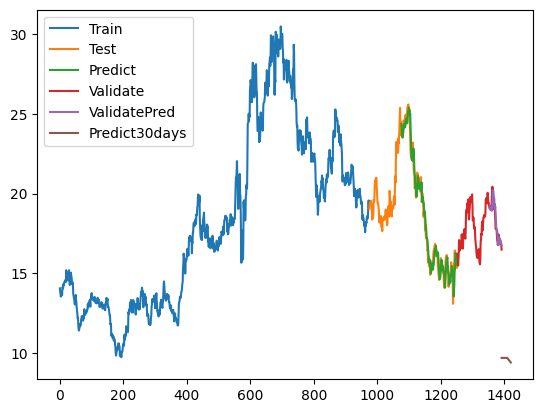

In [60]:
# 14.Plot
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()